# Risiko Detection: Boxes Analisys #
Here we will analyze the properties of the bounding boxes specified as text files inside the directory specified as *labels_path*.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import cv2
plt.rcParams['figure.figsize'] = [9, 9]

from IPython.display import display_html

In [2]:
generated_labels_path = "Generated_Dataset/labels"
generated_images_path = "Generated_Dataset/images"
generated_img_dims = np.array((640,640), dtype=np.float32)

real_labels_path = "Professor_Material/real_images/labels"
real_images_path = "Professor_Material/real_images/images"

#### Read Data ####
Read labels files, compute areas and ratios and do some statistics

In [3]:
generated_labels_files = sorted( filter( lambda x: os.path.isfile(os.path.join(generated_labels_path, x)),os.listdir(generated_labels_path) ) )
real_labels_files = sorted( filter( lambda x: os.path.isfile(os.path.join(real_labels_path, x)),os.listdir(real_labels_path) ) )


real_img_dims = np.zeros([len(real_labels_files), 2], dtype=np.float32)
for i in range(len(real_labels_files)):
    img_path = os.path.join(real_images_path, os.path.splitext(real_labels_files[i])[0] + ".jpg")
    img = cv2.imread(img_path)
    real_img_dims[i,0] = img.shape[1]
    real_img_dims[i,1] = img.shape[0]

real_img_stats = np.hstack([real_img_dims, np.expand_dims(real_img_dims[:,0]/real_img_dims[:,1], 1), np.expand_dims(real_img_dims[:,0]*real_img_dims[:,1], 1), np.expand_dims(np.sqrt(real_img_dims[:,0]*real_img_dims[:,1]), 1)])

df = pd.DataFrame(real_img_stats)
df.columns = ["img width", "img height", "img ratio", "img area", "img root area"]
df.describe()

,img width,img height,img ratio,img area,img root area
count,41.000000,41.000000,41.000000,41.00,41.000000
mean,2079.634033,1196.561035,1.661883,3381436.00,1564.847290
std,1431.891968,678.796570,0.400520,3456322.75,977.755615
min,382.000000,287.000000,0.562390,109634.00,331.110260
25%,900.000000,565.000000,1.402279,511668.00,715.309753
50%,1600.000000,1080.000000,1.777778,1806400.00,1344.023804
75%,4000.000000,2000.000000,2.000000,8000000.00,2828.427246
max,4000.000000,2559.000000,2.255357,8731308.00,2954.878662


In [4]:
real_labels_list = []
real_boxes = np.empty([0,4], dtype=np.float32)

for i in range(len(real_labels_files)):
    lbl = np.loadtxt(os.path.join(real_labels_path, real_labels_files[i]), dtype=np.float32)
    if lbl.shape[0] == 0:
        continue
    elif len(lbl.shape) == 1:
        lbl = np.expand_dims(lbl, 0)

    # Scale boxes centers and sizes
    np.multiply(lbl[:,1:], np.hstack([real_img_dims[i], real_img_dims[i]]), out=lbl[:,1:])

    np.round(lbl, out=lbl)

    real_labels_list.append(lbl)
    real_boxes = np.vstack([real_boxes, lbl[:,1:]], dtype=np.float32)

real_sizes = real_boxes[:,2:]
real_areas = real_sizes[:,0] * real_sizes[:,1]
real_ratios = real_sizes[:,0] / real_sizes[:,1]
real_df = pd.DataFrame(np.hstack([real_sizes, real_areas.reshape([real_areas.shape[0],1]), real_ratios.reshape([real_ratios.shape[0],1])]))
real_df.columns = ["Real Width", "Real Height", "Real Area", "Real Ratio"]
real_df_styler = real_df.describe(percentiles=[0.02,0.1,0.25,0.5,0.75,0.9,0.98]).style.set_table_attributes("style='display:inline'").set_caption('Real')

generated_labels_list = []
generated_boxes = np.empty([0,4], dtype=np.float32)

for i in range(len(generated_labels_files)):
    lbl = np.loadtxt(os.path.join(generated_labels_path, generated_labels_files[i]), dtype=np.float32)
    if lbl.shape[0] == 0:
        continue
    elif len(lbl.shape) == 1:
        lbl = np.expand_dims(lbl, 0)

    # Scale boxes centers and sizes
    np.multiply(lbl[:,1:], np.hstack([generated_img_dims, generated_img_dims]), out=lbl[:,1:])

    np.round(lbl, out=lbl)

    generated_labels_list.append(lbl)
    generated_boxes = np.vstack([generated_boxes, lbl[:,1:]], dtype=np.float32)

generated_sizes = generated_boxes[:,2:]
generated_areas = generated_sizes[:,0] * generated_sizes[:,1]
generated_ratios = generated_sizes[:,0] / generated_sizes[:,1]
generated_df = pd.DataFrame(np.hstack([generated_sizes, generated_areas.reshape([generated_areas.shape[0],1]), generated_ratios.reshape([generated_ratios.shape[0],1])]))
generated_df.columns = ["Gen Width", "Gen Height", "Gen Area", "Gen Ratio"]
generated_df_styler = generated_df.describe(percentiles=[0.02,0.1,0.25,0.5,0.75,0.9,0.98]).style.set_table_attributes("style='display:inline'").set_caption('Generated')

display_html(real_df_styler._repr_html_()+generated_df_styler._repr_html_(), raw=True)

,Real Width,Real Height,Real Area,Real Ratio
count,5143.000000,5143.000000,5143.000000,5143.000000
mean,52.043556,44.949253,2863.404785,1.271307
std,28.251400,25.513840,2753.578369,0.493069
min,4.000000,3.000000,12.000000,0.275862
2%,7.000000,6.000000,42.000000,0.520000
10%,15.000000,12.000000,204.000000,0.672250
25%,29.000000,22.000000,622.000000,0.878049
50%,53.000000,45.000000,2680.000000,1.216667
75%,74.000000,63.000000,4224.500000,1.600000
90%,86.000000,78.000000,5888.000000,1.930233


Now we check some statistics about the IoU in each image

In [5]:
def IoU(boxes:np.ndarray) -> float:

    half_dims = boxes[:, 2:] / 2
    x1 = boxes[:, 0] - half_dims[:, 0]
    x2 = boxes[:, 0] + half_dims[:, 0]
    y1 = boxes[:, 1] - half_dims[:, 1]
    y2 = boxes[:, 1] + half_dims[:, 1]

    xA = np.maximum(x1, np.expand_dims(x1, 1))
    yA = np.maximum(y1, np.expand_dims(y1, 1))
    xB = np.minimum(x2, np.expand_dims(x2, 1))
    yB = np.minimum(y2, np.expand_dims(y2, 1))

    interArea = np.maximum((xB - xA), 0) * np.maximum((yB - yA), 0)

    boxesArea = (x2 - x1) * (y2 - y1)
    unionArea = boxesArea + np.expand_dims(boxesArea,1) - interArea

    IoU = interArea / unionArea

    IoU = IoU[~np.eye(IoU.shape[0],dtype=bool)].reshape(IoU.shape[0],-1)

    IoU = IoU.flatten()

    return np.max(IoU)

real_max_img_iou_list = np.empty([0], dtype=np.float32)
for boxes in real_labels_list:
    if boxes.shape[0] > 1:
        real_max_img_iou_list = np.hstack([real_max_img_iou_list, IoU(boxes[:,1:])])
real_df = pd.DataFrame(real_max_img_iou_list)
real_df.columns= ["Real max IoU in each img"]
real_df_styler = real_df.describe(percentiles=[0.02,0.1,0.25,0.5,0.75,0.9,0.98]).style.set_table_attributes("style='display:inline'").set_caption('Real')

generated_max_img_iou_list = np.empty([0], dtype=np.float32)
for boxes in generated_labels_list:
    if boxes.shape[0] > 1:
        generated_max_img_iou_list = np.hstack([generated_max_img_iou_list, IoU(boxes[:,1:])])
generated_df = pd.DataFrame(generated_max_img_iou_list)
generated_df.columns= ["Generated max IoU each img"]
generated_df_styler = generated_df.describe(percentiles=[0.02,0.1,0.25,0.5,0.75,0.9,0.98]).style.set_table_attributes("style='display:inline'").set_caption('Generated')

display_html(real_df_styler._repr_html_()+generated_df_styler._repr_html_(), raw=True)

,Real max IoU in each img
count,41.000000
mean,0.329081
std,0.166215
min,0.000000
2%,0.000000
10%,0.087071
25%,0.220553
50%,0.338091
75%,0.430904
90%,0.528169


#### Plot all bounding boxes sizes ####

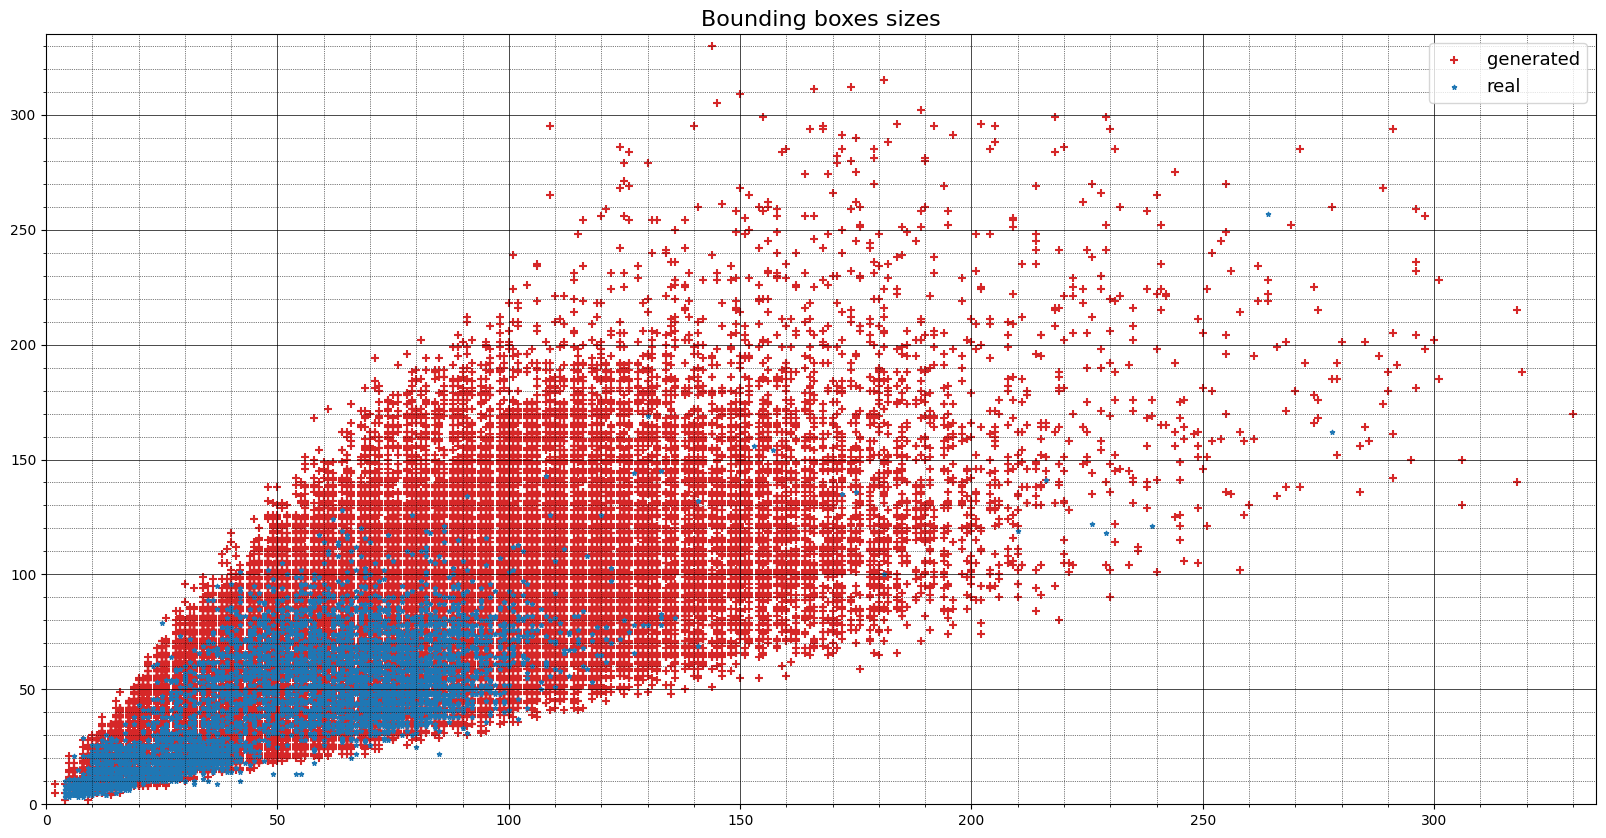

In [6]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.scatter(generated_sizes[:,0], generated_sizes[:,1], s=40, marker='+', c='tab:red', label='generated')
plt.scatter(real_sizes[:,0], real_sizes[:,1], s=10, marker='*', c='tab:blue', label='real')
plt.xlim([0,max(real_sizes[:,0].max(), generated_sizes[:,0].max())+5])
plt.ylim([0,max(real_sizes[:,1].max(), generated_sizes[:,0].max())+5])
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.minorticks_on()
plt.title('Bounding boxes sizes', fontsize=16)
plt.legend(fontsize=13)
plt.show()

Get histogram on areas to estimate size

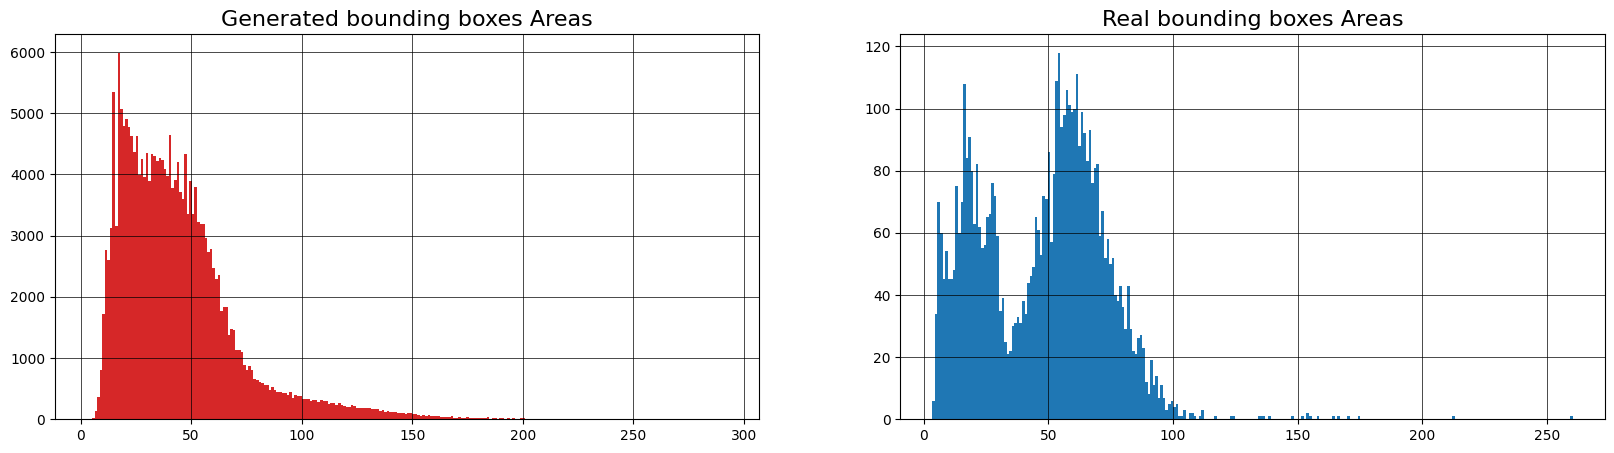

In [7]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.subplot(1,2,1)
plt.title('Generated bounding boxes Areas', fontsize=16)
plt.hist(np.sqrt(generated_areas), bins=250, color='tab:red', label='generated')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.subplot(1,2,2)
plt.title('Real bounding boxes Areas', fontsize=16)
plt.hist(np.sqrt(real_areas), bins=250, color='tab:blue', label='real')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## KMeans Clustering ##
Now we run some clustering to identify patterns in the data. This will useful when generating the neural network model and detecting the tanks and flags.
In particular this results will be useful when chosing the anchor boxes size and ratios

#### Clustering plot function ####

In [8]:
def plot_clusters(points:np.ndarray, labels:np.ndarray, k:int, centers, plot_centers:bool=False):
    sorted_centers = np.argsort(centers)

    # plot the 3 clusters
    colors = ["green", "darkorange", "purple", "blue", "lightblue", "lightgreen"]
    for i in range(k):
        plt.scatter(points[labels == sorted_centers[i], 0], points[labels == sorted_centers[i], 1], s=10, c=colors[i], marker='.', label="center at " + str(centers[sorted_centers[i]]))

    # plot the centroids
    if plot_centers:
        plt.scatter(centers[:, 0], centers[:, 1], s=20, marker='o', c='red', edgecolor='black', label='centroids')

    plt.legend(scatterpoints=1)
    plt.minorticks_on()
    plt.xlim([0,points[:,0].max()+20])
    plt.ylim([0,points[:,1].max()+20])
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

#### Clustering on Size ####

Real dataset kmeans centers: [ 730.1655 3802.4636 8055.6665]
Generated dataset kmeans centers: [ 1617.6927  8853.512  23931.209 ]


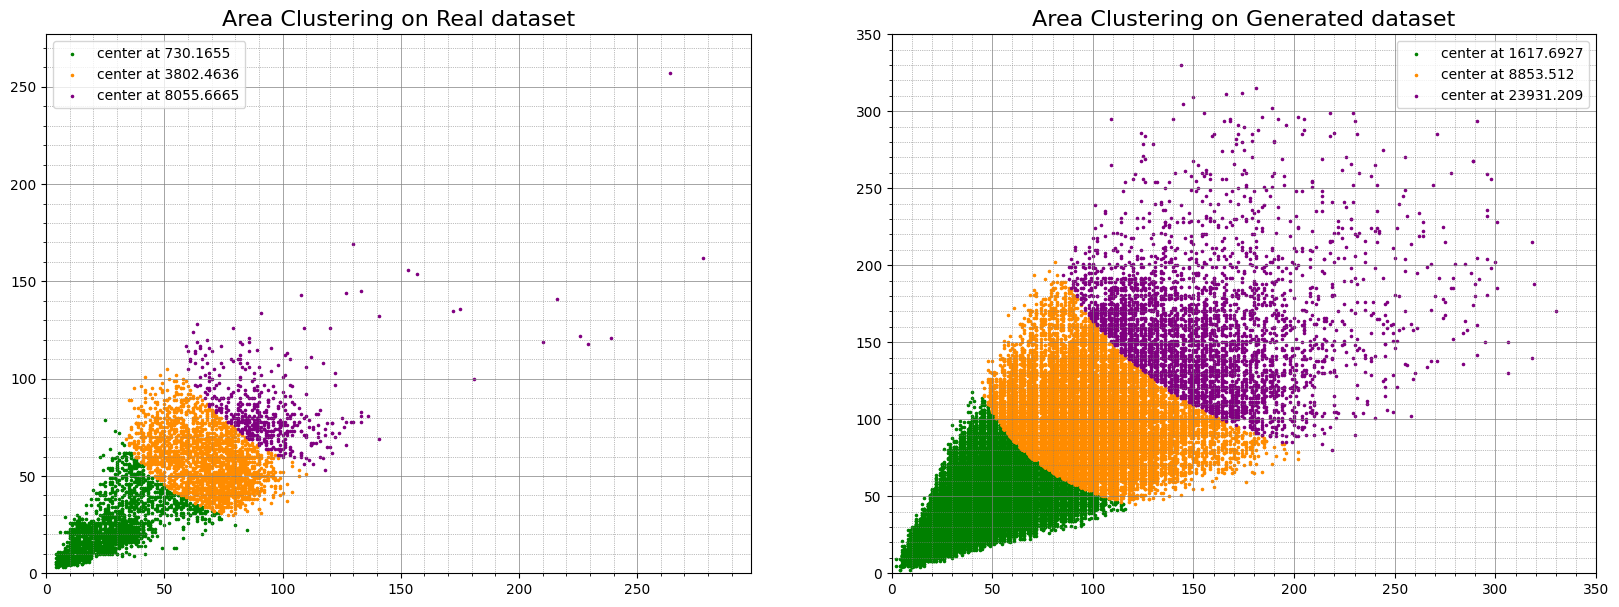

In [9]:
k_sizes = 3
real_km_size = KMeans(n_clusters=k_sizes, n_init='auto')
real_km_sizes_output = real_km_size.fit_predict(np.expand_dims(real_areas, 1))
print('Real dataset kmeans centers: ' + str(np.sort(real_km_size.cluster_centers_.squeeze(), 0)))

k_sizes = 3
generated_km_size = KMeans(n_clusters=k_sizes, n_init='auto')
generated_km_sizes_output = generated_km_size.fit_predict(np.expand_dims(generated_areas, 1))
print('Generated dataset kmeans centers: ' + str(np.sort(generated_km_size.cluster_centers_.squeeze(), 0)))

plt.rcParams['figure.figsize'] = [20, 7]
plt.subplot(1,2,1)
plt.title('Area Clustering on Real dataset', fontsize=16)
plot_clusters(real_sizes, real_km_sizes_output, k_sizes, real_km_size.cluster_centers_.squeeze())
plt.subplot(1,2,2)
plt.title('Area Clustering on Generated dataset', fontsize=16)
plot_clusters(generated_sizes, generated_km_sizes_output, k_sizes, generated_km_size.cluster_centers_.squeeze())
plt.show()

#### Clustering on Ratios

Real dataset kmeans centers: [0.7944186 1.340185  1.9793699]
Generated dataset kmeans centers: [0.7612995 1.2399143 1.7629758]


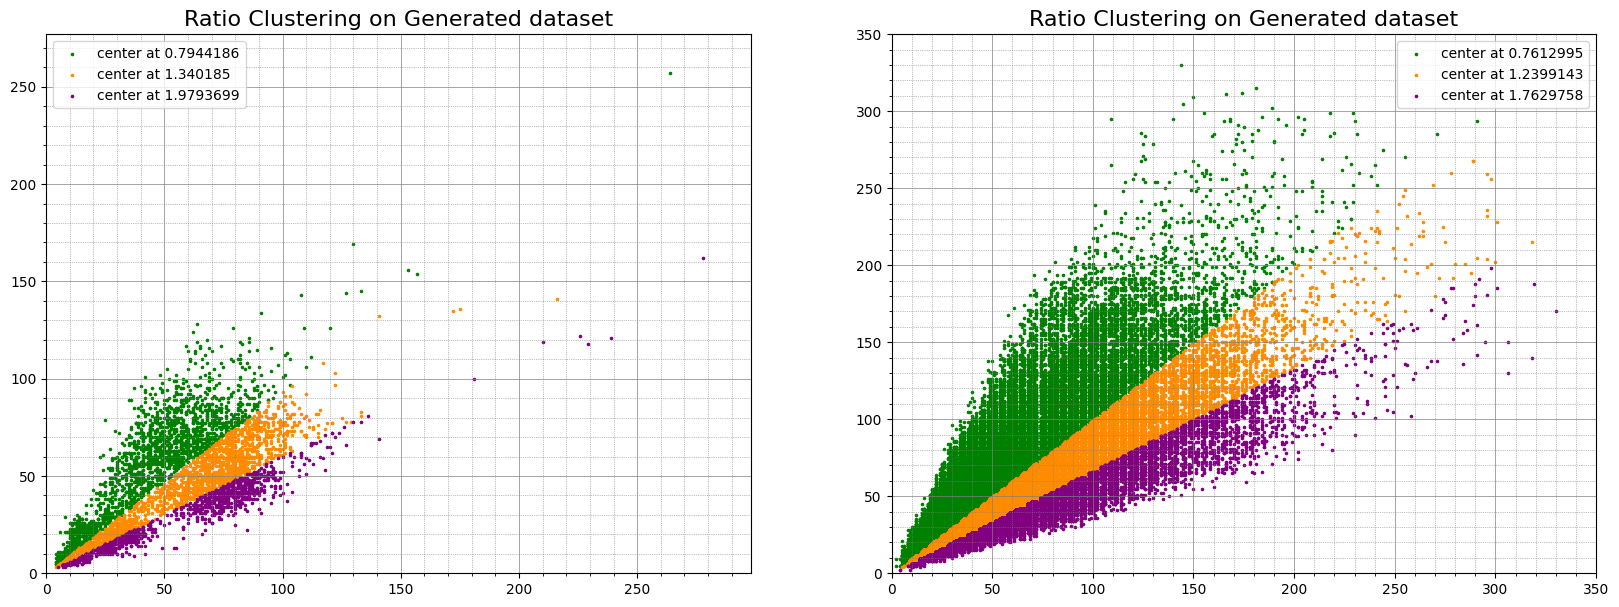

In [10]:
k_ratios = 3

real_km_ratios = KMeans(n_clusters=k_ratios, n_init='auto')
real_km_ratios_output = real_km_ratios.fit_predict(np.expand_dims(real_ratios, 1))
print('Real dataset kmeans centers: ' + str(np.sort(real_km_ratios.cluster_centers_.squeeze())))

generated_km_ratios = KMeans(n_clusters=k_ratios, n_init='auto')
generated_km_ratios_output = generated_km_ratios.fit_predict(np.expand_dims(generated_ratios, 1))
print('Generated dataset kmeans centers: ' + str(np.sort(generated_km_ratios.cluster_centers_.squeeze())))

plt.rcParams['figure.figsize'] = [20, 7]
plt.subplot(1,2,1)
plt.title('Ratio Clustering on Generated dataset', fontsize=16)
plot_clusters(real_sizes, real_km_ratios_output, k_ratios, real_km_ratios.cluster_centers_.squeeze())
plt.subplot(1,2,2)
plt.title('Ratio Clustering on Generated dataset', fontsize=16)
plot_clusters(generated_sizes, generated_km_ratios_output, k_ratios, generated_km_ratios.cluster_centers_.squeeze())
plt.show()